# Heat Stress Project - Milk Yield

# R Packages

In [1]:
suppressPackageStartupMessages({
  library(mgcv)
  library(arrow)
  library(dplyr)
  library(tictoc)
  library(fixest)
  library(plm)
  library(lspline)
  library(lmerTest)
  library(ggplot2)
  library(car)
  library(tidyverse)
  library(lmtest)
  library(rsample)
  library(rlang)
})
options(width=1000)

# Experiment Parameters

In [2]:
set.seed(2024)
period <- 1999:2023
month <- 4:10
start <- min(period)
stop <- max(period)
subsample <- F
diagnostic <- F
save <- F
sample_size <- 100000
dependent_var <- "milk_fpcm"
weather_var <- "thi_mean_t0_3d"
breeds <- c("HO", "JE", "SI", "SF", "BS", "OB")
start_knot <- 45
stop_knot <- 65
concatenated_string <- paste0("17_reduced_form_model_thi_mean_t0_3d_fixed_effect_", start, "-", stop, "_", format(Sys.time(), "%Y_%m_%d_%H_%M_%S"), "_", dependent_var)
concatenated_string

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm"

# Custom Functions

In [3]:
generate_diagnostic_plots <- function(model) {
  # Extract fitted values and residuals
  fitted_values <- fitted(model)
  residuals <- residuals(model)
  
  # Create a data frame for plotting
  plot_data <- data.frame(fitted_values = fitted_values, residuals = residuals)
  print(nrow(plot_data))
  
  # Residuals vs Fitted Values Plot / Linearity & Homoscedacity
  p1 <- ggplot(plot_data, aes(x = fitted_values, y = residuals)) +
    geom_point(alpha = 0.5) +                       # Scatter plot of residuals
    geom_smooth(method = "loess", col = "red", se = FALSE) +    # Smooth curve (loess)
    labs(title = "Residuals vs. Fitted Values",
         x = "Fitted Values",
         y = "Residuals") +
    theme_minimal() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "blue")
  
  # Normal distribution of residuals
  p2 <- ggplot(plot_data, aes(sample = residuals)) +
    stat_qq() +
    stat_qq_line() +
    labs(title = "Normal Q-Q",
         x = "Theoretical Quantiles",
         y = "Residuals") +
    theme_minimal()
  
  # Scale-Location Plot (Homoscedacity - normally distributed standard error)
  plot_data$std_residuals <- scale(residuals)
  plot_data$abs_sqrt_residuals <- sqrt(abs(plot_data$std_residuals))
  
  p3 <- ggplot(plot_data, aes(fitted_values, abs_sqrt_residuals)) +
    geom_point() +
    geom_smooth(method = "loess", col = "red", se = FALSE) +
    labs(title = "Scale-Location Plot",
         x = "Fitted values",
         y = "√|Standardized residuals|") +
    theme_minimal()

  p4 <- ggplot(plot_data, aes(x = residuals)) +
    geom_histogram(binwidth = 0.5, fill = "blue", color = "black") +
    labs(title = "Histogram of Residuals", x = "Residuals", y = "Frequency") +
    theme_minimal()
 
  # Return the plots as a list
  list(
    Residuals_vs_Fitted = p1,
    Normal_QQ = p2,
    Scale_Location = p3,
    Residual_hist = p4
  )
}

In [4]:
create_effect_plot <- function(data, model, knot, response_var, predictor_var, breed) {
  # Create the range for the predictor variable
  predictor_range <- seq(ceiling(min(data[predictor_var], na.rm = TRUE)), floor(max(data[predictor_var], na.rm = TRUE)))
  # Calculate the effect
  effect <- lspline(predictor_range, knots = knot) %*% coeftest(model)[,1][1:(length(knot)+1)]
  
  # Calculate the confidence intervals
  effect_error_min <- effect - ((lspline(predictor_range, knots = knot)) %*% (abs(coeftest(model)[,2][1:(length(knot)+1)] * 1.96)))
  effect_error_max <- effect + ((lspline(predictor_range, knots = knot)) %*% (abs(coeftest(model)[,2][1:(length(knot)+1)] * 1.96)))
  
  # Create the data frame for plotting
  data_plot <- data.frame(
    breed = breed,
    predictor_range, 
    Effect = effect, 
    Lower = effect_error_min, 
    Upper = effect_error_max
  )
  
  # Create the plot
  plot <- ggplot(data_plot, aes(x = predictor_range, y = Effect)) +
    geom_line(color = "blue") +
    geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.3, fill = "blue") +
    labs(
      title = paste("Effect of", predictor_var, "with Confidence Intervals"),
      x = paste(predictor_var, "Range"),
      y = "Effect"
    ) +
    theme_minimal() + 
    scale_x_continuous(breaks = seq(40, 90, by = 10), limits = c(40, max(predictor_range))) +
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.title.position = "plot",
      axis.title.x = element_text(hjust = 0.5),
      axis.title.y = element_text(hjust = 0.5)
    )
  
  return(list(plot = plot, data = data_plot))
}

merge_plot_data <- function(plot_data_list) {
  # Combine the data frames from each plot into one data frame
  merged_data <- bind_rows(plot_data_list)
  
  return(merged_data)
}

# Load Data

In [5]:
milk_data <- read_parquet("/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/12_base_data.parquet")

In [6]:
milk_data$animalBreedCode <- as.factor(milk_data$animalBreedCode)
milk_data$milk_fpcm <- milk_data$milk*(0.0337 + 0.116*milk_data$fat + 0.06*milk_data$protein)
milk_data$year <- as.factor(milk_data$year)
milk_data$farmId <- as.factor(milk_data$farmId)
milk_data$month <- as.factor(milk_data$month)
milk_data$logmilk <- log(milk_data$milk)
milkingMehtod <- as.factor(milk_data$milkingMethod)
milk_data$zip <- as.factor(milk_data$zip)
milk_data$days_in_milk <- as.numeric(milk_data$days_in_milk)
milk_data$days_in_milk <- milk_data$days_in_milk / 86400
milk_data$farm_year_interaction = interaction(milk_data$farmId, milk_data$year)
milk_data$farm_month_interaction = interaction(milk_data$farmId, milk_data$month)

milk_data$regular_season <- with(milk_data, 
    ifelse(month %in% c("3", "4", "5"), "spring",
    ifelse(month %in% c("6", "7", "8"), "summer",
    ifelse(month %in% c("9", "10", "11"), "fall", "winter"))))

# Convert the new variable to a factor
milk_data$regular_season <- as.factor(milk_data$regular_season)
milk_data$zip_regular_season <- interaction(milk_data$zip, milk_data$regular_season)

# Create the interaction term between farmId and month_range
milk_data$farmId_regular_season_interaction <- interaction(milk_data$farmId, milk_data$regular_season)

milk_data$farm_season <- with(milk_data, 
    ifelse(month %in% c("4", "5", "6", "7", "8", "9"), "grazing", "nongrazing"))

# Convert the new variable to a factor
milk_data$farm_season <- as.factor(milk_data$farm_season)

# Create the interaction term between farmId and farm_seasons
milk_data$farmId_farm_season_interaction <- interaction(milk_data$farmId, milk_data$farm_season)

In [7]:
milk_data <- subset(milk_data, year %in% period)
milk_data <- subset(milk_data, month %in% month)

In [8]:
if (subsample) { 
    milk_data <- milk_data %>%
      group_by(year, animalBreedCode) %>%
      sample_frac(sample_size/nrow(milk_data)) %>% drop_na(get(weather_var))
}

In [9]:
milk_data <- droplevels(milk_data)

split data for each breed

In [10]:
je <- droplevels(subset(milk_data, animalBreedCode %in% c("JE")) %>% drop_na(!!weather_var))
bs <- droplevels(subset(milk_data, animalBreedCode %in% c("BS")) %>% drop_na(!!weather_var))
ho <- droplevels(subset(milk_data, animalBreedCode %in% c("HO")) %>% drop_na(!!weather_var))
ob <- droplevels(subset(milk_data, animalBreedCode %in% c("OB")) %>% drop_na(!!weather_var))
si <- droplevels(subset(milk_data, animalBreedCode %in% c("SI")) %>% drop_na(!!weather_var))
sf <- droplevels(subset(milk_data, animalBreedCode %in% c("SF")) %>% drop_na(!!weather_var))

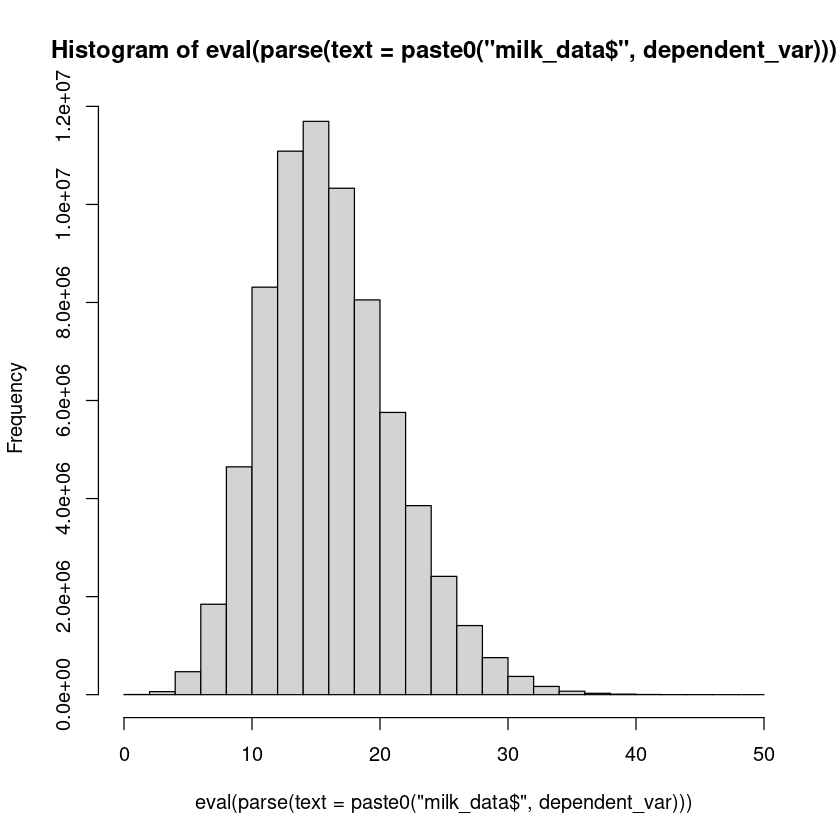

In [11]:
hist(eval(parse(text = paste0("milk_data$", dependent_var))))

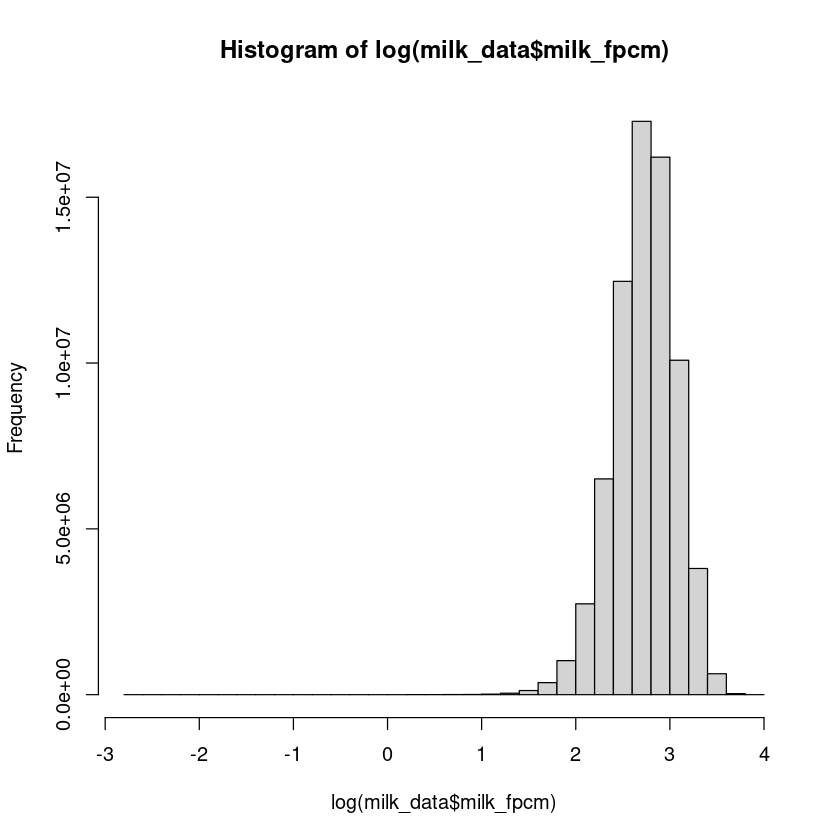

In [12]:
hist(log(milk_data$milk_fpcm))

In [13]:
rm(milk_data)

# Piecewise Linear THI - Reduced Form Piecewise Linear Fixed Effect Model

In [14]:
pl_clu <- c("year", "farmId")

run_models_with_knots <- function(data, knot_sequence, dep_var_name, weather_var) {
  best_rss <- Inf
  best_knot_comb <- NULL
  
  # Loop over each knot value
  for (i in 1:length(knot_sequence)) {
    knots <- paste(knot_sequence[[i]], collapse = ",")
    
    f <- paste0(dep_var_name, "~", "lspline(", weather_var, ", knots=c(", knots, ")) + days_in_milk + lactationNumber + precip_mean_t0_3d + precip_mean_t0_3d^2 + year | farmId")
    pl_form <- as.formula(f)
    model <- feols(pl_form, data = data, cluster = pl_clu)
    
    # Calculate RSS for the current model
    current_rss <- sum(residuals(model)^2)
    
    # Check if this model has the lowest RSS so far
    if (current_rss < best_rss) {
      best_rss <- current_rss
      best_knot_comb <- knot_sequence[[i]]
    }
  }
  
  # Recompute the best model for storage reasons
  knots <- paste(best_knot_comb, collapse = ",")
  f <- paste0(dep_var_name, "~", "lspline(", weather_var, ", knots=c(", knots, ")) + days_in_milk + lactationNumber + precip_mean_t0_3d + precip_mean_t0_3d^2 + year | farmId")
  pl_form <- as.formula(f)
  best_model <- feols(pl_form, data = data, cluster = pl_clu, lean = T)
  gc()
  
  # Return a list containing the best knot combination, the best model, and its RSS
  return(list(best_knot = best_knot_comb, best_model_rss = best_rss, best_model = best_model))
}



In [15]:
knot_combs <- list()
for (i in start_knot:stop_knot) {
    j <- i - start_knot + 1
  knot_combs[[j]] <- c(i)
}

In [16]:
#knot_combs[[length(knot_combs)+1]] <- seq(from = 0, to = 80, by = 5)

## Jersey

In [17]:
tic()
je_model = run_models_with_knots(droplevels(je), knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

21.779 sec elapsed


In [18]:
jersey_model_name <- paste0(concatenated_string, "_jersey_model.Rdata")
jersey_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm_jersey_model.Rdata"

In [19]:
if (save) {
    tic()
    saveRDS(je_model, file = jersey_model_name, compress=T)
    toc()
}

In [20]:
je_model$best_knot

[1] 51

In [21]:
summary(je_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 660,110
Fixed-effects: farmId: 4,629
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_mean_t0_3d, knots = c(51))1 -0.000071   0.003167  -0.022552 9.8219e-01    
lspline(thi_mean_t0_3d, knots = c(51))2 -0.064904   0.005200 -12.481608 5.5109e-12 ***
days_in_milk                            -0.016643   0.000542 -30.693926  < 2.2e-16 ***
lactationNumber                          0.549429   0.014522  37.833930  < 2.2e-16 ***
precip_mean_t0_3d                       -0.005843   0.005461  -1.069893 2.9531e-01    
I(precip_mean_t0_3d^2)                  -0.000242   0.000193  -1.251832 2.2269e-01    
year2000                                -0.044224   0.029265  -1.511130 1.4381e-01    
year2001                                 1.012427   0.020112  50.340193  < 2.2e-16 ***
year2002                                 1.593789   0.049351  32.294929  < 2.2e-16 **

Warning message:
“Removed 38 rows containing missing values or values outside the scale range (`geom_line()`).”


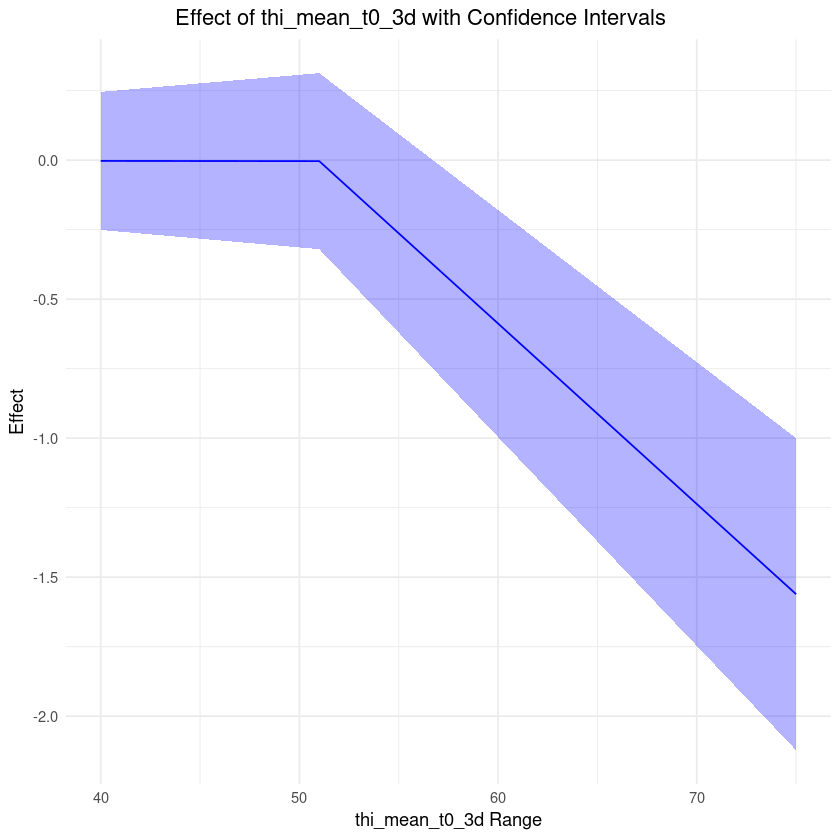

In [22]:
je_p <- create_effect_plot(je, je_model$best_model, je_model$best_knot, dependent_var, weather_var, "JE")
je_p$plot

## Holstein

In [23]:
tic()
ho_model = run_models_with_knots(ho, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

534.463 sec elapsed


Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



575.658 sec elapsed


In [24]:
ho_model_name <- paste0(concatenated_string, "_ho_model.Rdata")
ho_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm_ho_model.Rdata"

In [25]:
if (save) {
    tic()
    saveRDS(ho_model, file = ho_model_name, compress=TRUE)
    toc()
}

In [26]:
ho_model$best_knot

[1] 51

In [27]:
summary(ho_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 22,273,344
Fixed-effects: farmId: 24,321
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_mean_t0_3d, knots = c(51))1 -0.000922   0.002096  -0.439971 6.6389e-01    
lspline(thi_mean_t0_3d, knots = c(51))2 -0.069715   0.003405 -20.473825  < 2.2e-16 ***
days_in_milk                            -0.024804   0.000506 -49.062749  < 2.2e-16 ***
lactationNumber                          0.684660   0.008120  84.317138  < 2.2e-16 ***
precip_mean_t0_3d                       -0.000126   0.004605  -0.027393 9.7837e-01    
I(precip_mean_t0_3d^2)                  -0.000225   0.000169  -1.330228 1.9595e-01    
year2000                                -0.064416   0.009290  -6.933585 3.6008e-07 ***
year2001                                 0.169301   0.004650  36.407483  < 2.2e-16 ***
year2002                                 0.179240   0.002011  89.108144  < 2.2e-1

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


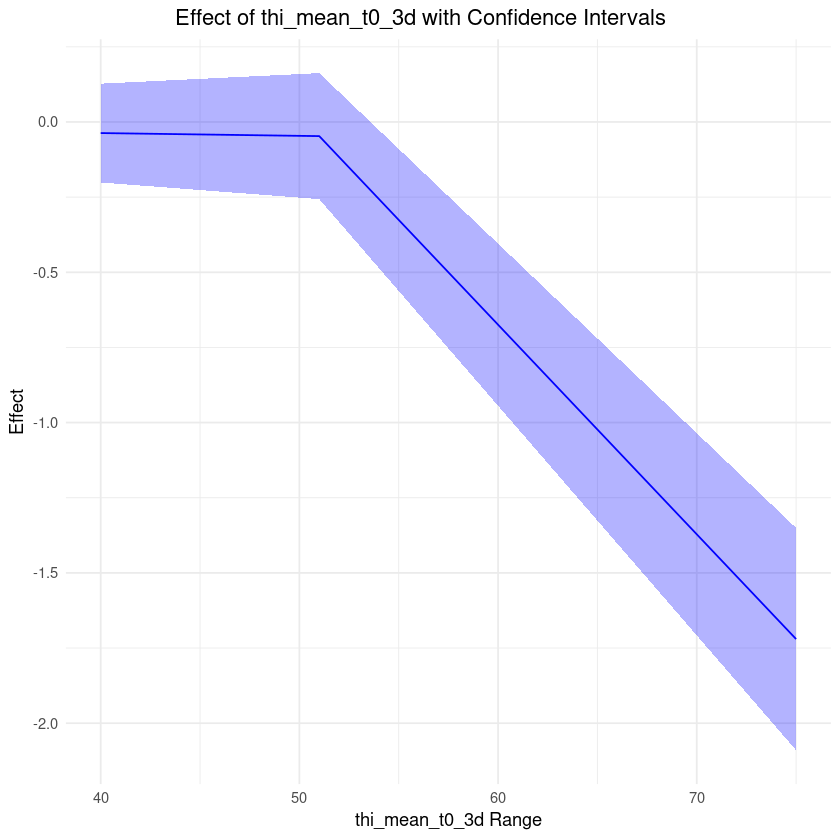

In [28]:
ho_p <- create_effect_plot(ho, ho_model$best_model, ho_model$best_knot, dependent_var, weather_var, "HO")
ho_p$plot

## Brown Swiss

In [29]:
tic()
bs_model = run_models_with_knots(bs, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

783.726 sec elapsed


Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



793.253 sec elapsed


In [30]:
bs_model_name <- paste0(concatenated_string, "_bs_model.Rdata")
bs_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm_bs_model.Rdata"

In [31]:
if (save) {
    tic()
    saveRDS(bs_model, file = bs_model_name, compress=T)
    toc()
}

In [32]:
bs_model$best_knot

[1] 50

In [33]:
summary(bs_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 29,798,989
Fixed-effects: farmId: 21,038
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_mean_t0_3d, knots = c(50))1 -0.006741   0.001939  -3.477204 1.9492e-03 ** 
lspline(thi_mean_t0_3d, knots = c(50))2 -0.046953   0.003924 -11.965375 1.3269e-11 ***
days_in_milk                            -0.020418   0.000406 -50.272363  < 2.2e-16 ***
lactationNumber                          0.448129   0.010181  44.017424  < 2.2e-16 ***
precip_mean_t0_3d                       -0.006509   0.002902  -2.243175 3.4384e-02 *  
I(precip_mean_t0_3d^2)                   0.000017   0.000108   0.154363 8.7861e-01    
year2000                                 0.013525   0.005805   2.329683 2.8562e-02 *  
year2001                                 0.695196   0.002057 338.001718  < 2.2e-16 ***
year2002                                 0.762936   0.001533 497.561811  < 2.2e-1

Warning message:
“Removed 43 rows containing missing values or values outside the scale range (`geom_line()`).”


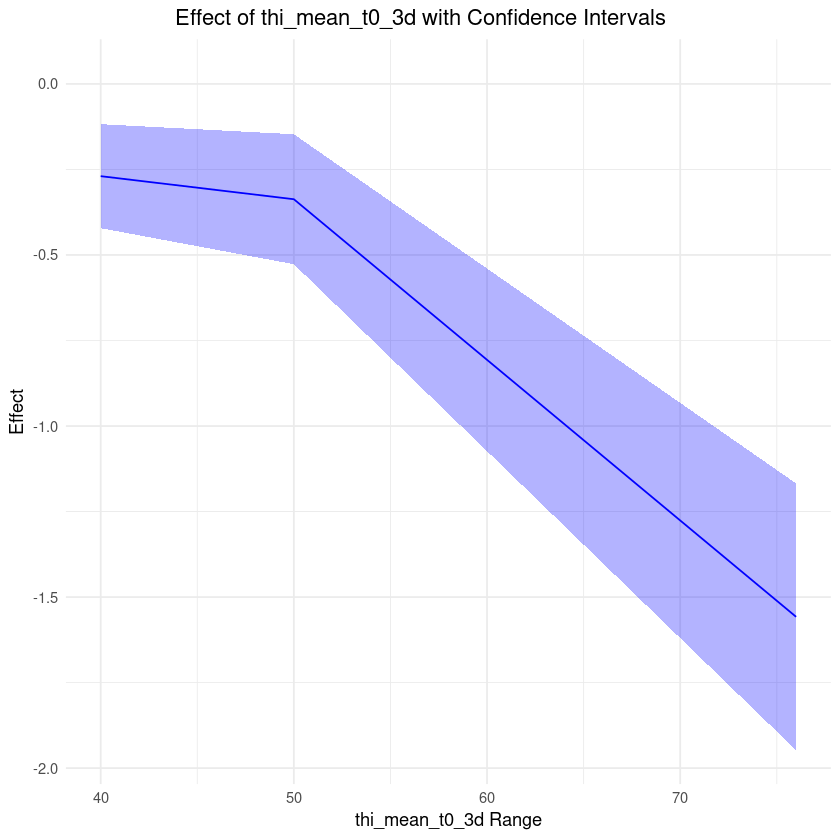

In [34]:
bs_p <- create_effect_plot(bs, bs_model$best_model, bs_model$best_knot, dependent_var, weather_var, "BS")
bs_p$plot

## Simmental

In [35]:
tic()
si_model = run_models_with_knots(si, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

95.397 sec elapsed


Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



96.853 sec elapsed


In [36]:
si_model_name <- paste0(concatenated_string, "_si_model.Rdata")
si_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm_si_model.Rdata"

In [37]:
if (save) {
    tic()
    saveRDS(si_model, file = si_model_name, compress=T)
    toc()
}

In [38]:
si_model$best_knot

[1] 52

In [39]:
summary(si_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 3,754,197
Fixed-effects: farmId: 12,101
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_mean_t0_3d, knots = c(52))1  0.008781   0.002201    3.99002 5.4037e-04 ***
lspline(thi_mean_t0_3d, knots = c(52))2 -0.048255   0.004503  -10.71514 1.2544e-10 ***
days_in_milk                            -0.022085   0.000145 -152.75524  < 2.2e-16 ***
lactationNumber                          0.439113   0.006448   68.09606  < 2.2e-16 ***
precip_mean_t0_3d                        0.007242   0.004135    1.75138 9.2653e-02 .  
I(precip_mean_t0_3d^2)                  -0.000452   0.000169   -2.67846 1.3139e-02 *  
year2000                                -0.221370   0.011031  -20.06834  < 2.2e-16 ***
year2001                                -0.162994   0.007033  -23.17667  < 2.2e-16 ***
year2002                                -0.357702   0.003892  -91.90407  < 2.2e-16

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


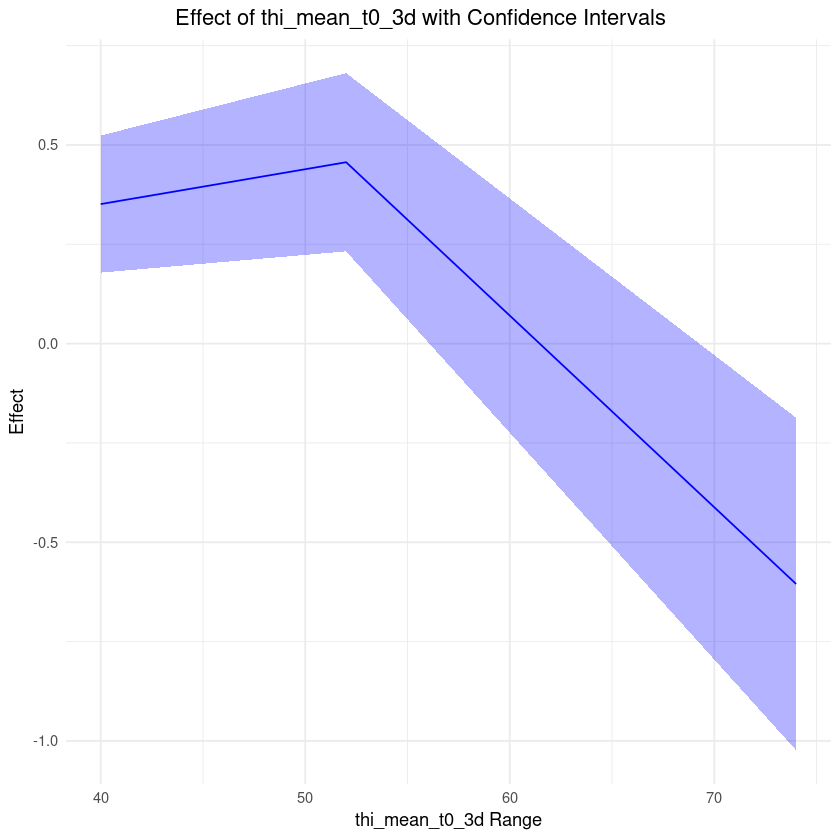

In [40]:
si_p <- create_effect_plot(si, si_model$best_model, si_model$best_knot, dependent_var, weather_var, "SI")
si_p$plot

## Swiss Fleckvieh

In [41]:
tic()
sf_model = run_models_with_knots(sf, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

335.697 sec elapsed


Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



391.645 sec elapsed


In [42]:
sf_model_name <- paste0(concatenated_string, "_sf_model.Rdata")
sf_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm_sf_model.Rdata"

In [43]:
if (save) {
    tic()
    saveRDS(sf_model, file = sf_model_name, compress=T)
    toc()
}

In [44]:
sf_model$best_knot

[1] 52

In [45]:
summary(sf_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 13,073,097
Fixed-effects: farmId: 25,332
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_mean_t0_3d, knots = c(52))1  0.009578   0.002147   4.461176 1.6348e-04 ***
lspline(thi_mean_t0_3d, knots = c(52))2 -0.056971   0.003802 -14.982698 1.1133e-13 ***
days_in_milk                            -0.025669   0.000398 -64.500464  < 2.2e-16 ***
lactationNumber                          0.494699   0.015669  31.571934  < 2.2e-16 ***
precip_mean_t0_3d                        0.000330   0.004035   0.081781 9.3550e-01    
I(precip_mean_t0_3d^2)                  -0.000133   0.000153  -0.867212 3.9441e-01    
year2000                                -0.059650   0.004499 -13.259830 1.5404e-12 ***
year2001                                 0.181355   0.004349  41.704511  < 2.2e-16 ***
year2002                                 0.178520   0.006981  25.570445  < 2.2e-1

Warning message:
“Removed 40 rows containing missing values or values outside the scale range (`geom_line()`).”


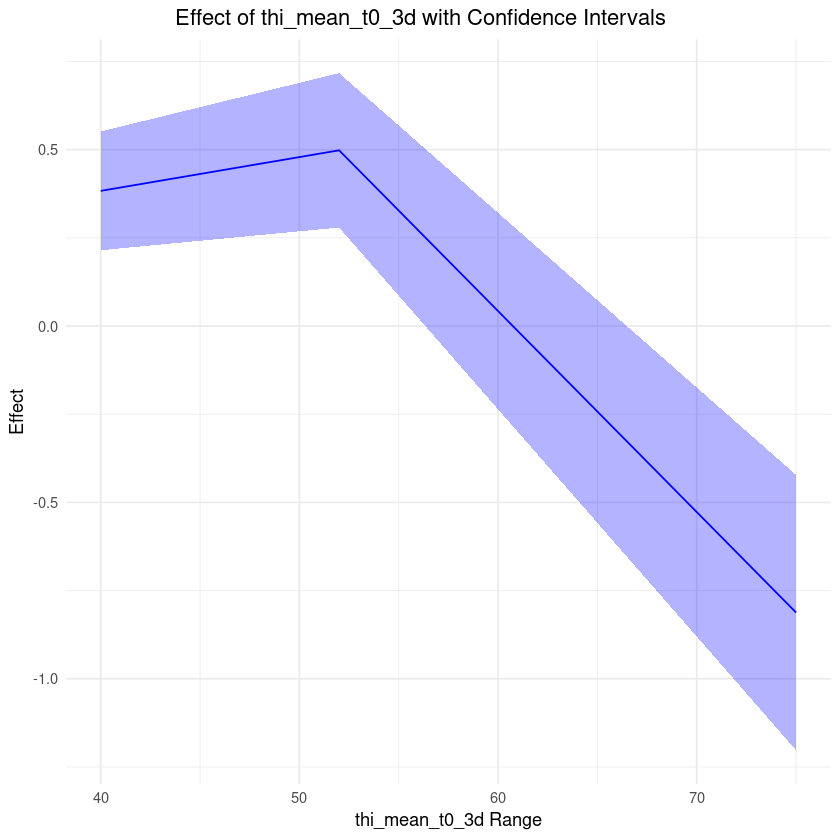

In [46]:
sf_p <- create_effect_plot(sf, sf_model$best_model, sf_model$best_knot, dependent_var, weather_var, "SF")
sf_p$plot

# Original Braunvieh

In [47]:
tic()
ob_model = run_models_with_knots(ob, knot_combs, dependent_var, weather_var)
toc()

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).

Variance contained negative values in

39.076 sec elapsed


Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



Variance contained negative values in the diagonal and was 'fixed' (a la Cameron, Gelbach & Miller 2011).



59.195 sec elapsed


In [48]:
ob_model_name <- paste0(concatenated_string, "_ob_model.Rdata")
ob_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_38_milk_fpcm_ob_model.Rdata"

In [49]:
if (save) {
    tic()
    saveRDS(ob_model, file = ob_model_name, compress=T)
    toc()
}

In [50]:
ob_model$best_knot

[1] 52

In [51]:
summary(ob_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 1,785,084
Fixed-effects: farmId: 7,002
Standard-errors: Clustered (year & farmId) 
                                         Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_mean_t0_3d, knots = c(52))1  0.000384   0.001848   0.207906 8.3706e-01    
lspline(thi_mean_t0_3d, knots = c(52))2 -0.039302   0.004112  -9.558358 1.1788e-09 ***
days_in_milk                            -0.019528   0.000225 -86.929413  < 2.2e-16 ***
lactationNumber                          0.402079   0.013605  29.552924  < 2.2e-16 ***
precip_mean_t0_3d                        0.000937   0.003820   0.245222 8.0837e-01    
I(precip_mean_t0_3d^2)                  -0.000128   0.000148  -0.865452 3.9536e-01    
year2000                                 0.007825   0.029126   0.268652 7.9049e-01    
year2001                                 0.425627   0.015609  27.267390  < 2.2e-16 ***
year2002                                 0.458735   0.013295  34.503384  < 2.2e-16 

Warning message:
“Removed 42 rows containing missing values or values outside the scale range (`geom_line()`).”


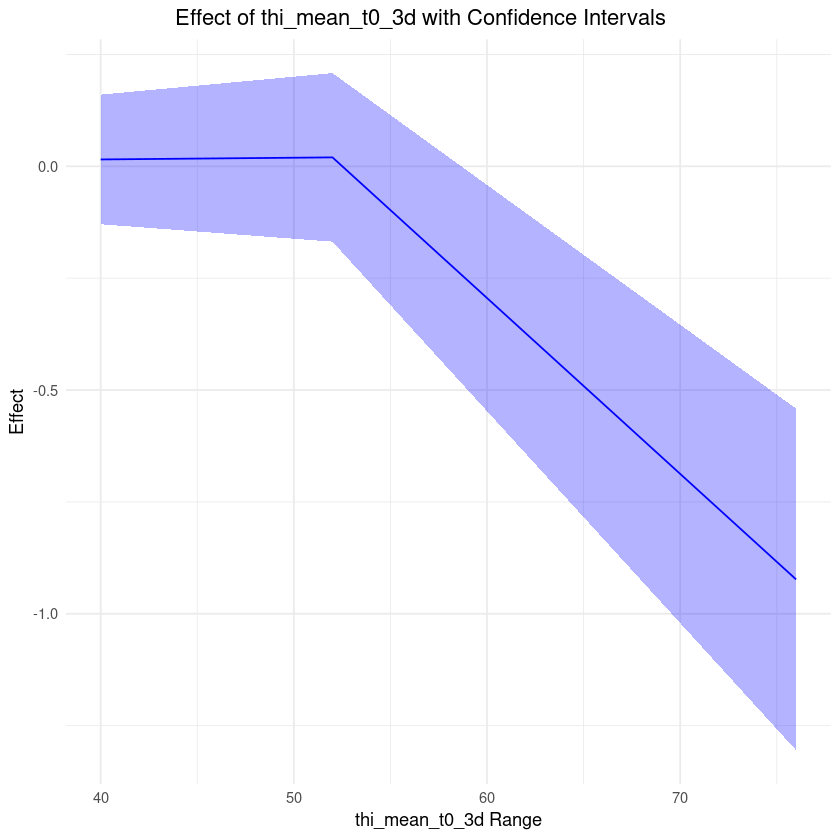

In [52]:
ob_p <- create_effect_plot(ob, ob_model$best_model, ob_model$best_knot, dependent_var, weather_var, "OB")
ob_p$plot

## Merge data

In [53]:
breed_effect_data <- merge_plot_data(list(ho_p$data, bs_p$data, sf_p$data, si_p$data, bs_p$data, je_p$data, ob_p$data))
saveRDS(breed_effect_data, file = paste0(concatenated_string, "_plot_data.Rdata"), compress=T)

In [55]:
# Function to plot merged data
plot_merged_data <- function(merged_data, predictor_var) {
  # Create the plot
    
    y_min <- min(merged_data$Lower)
    y_max <- max(merged_data$Upper)
    plot <- ggplot(merged_data, aes(x = predictor_range, y = Effect, color = breed, fill = breed)) +
    geom_line() +
    geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.3) +
    labs(
      title = paste0("Effect of", predictor_var, " per breed"),
      x = "Predictor Variable Range",
      y = "Effect"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(40,  max(merged_data$predictor_range), by = 10), limits = c(40, max(merged_data$predictor_range))) +
    scale_y_continuous(limits = c(y_min, y_max)) +
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.title.position = "plot",
      axis.title.x = element_text(hjust = 0.5),
      axis.title.y = element_text(hjust = 0.5)
    ) +
    facet_wrap(~ breed)
  
  
  return(plot)
}

Warning message:
“Removed 288 rows containing missing values or values outside the scale range (`geom_line()`).”


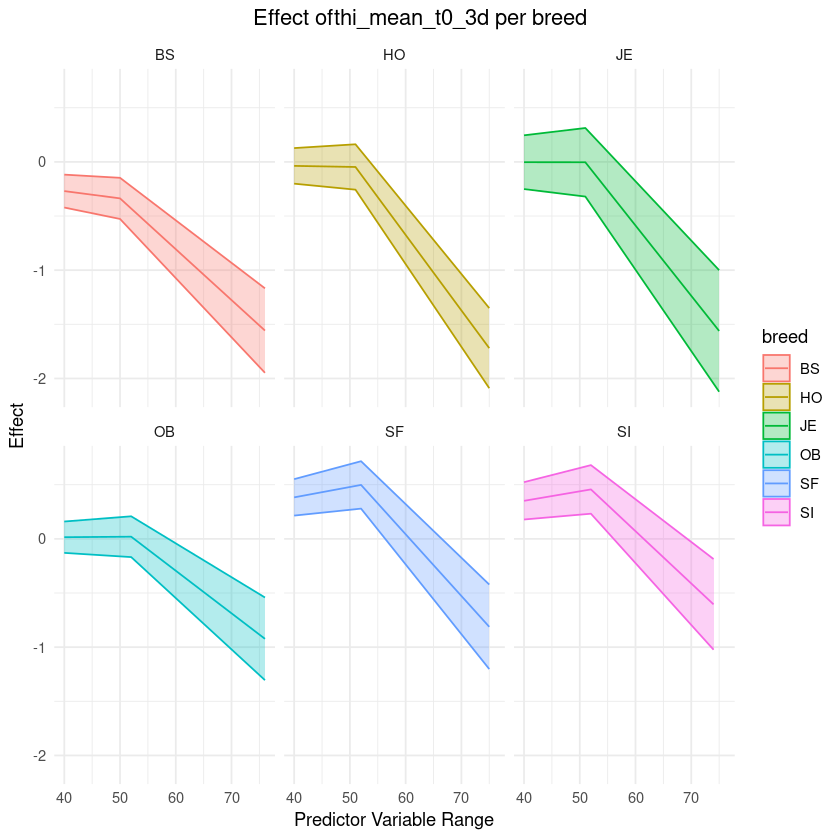

In [56]:
plot_merged_data(breed_effect_data, weather_var)